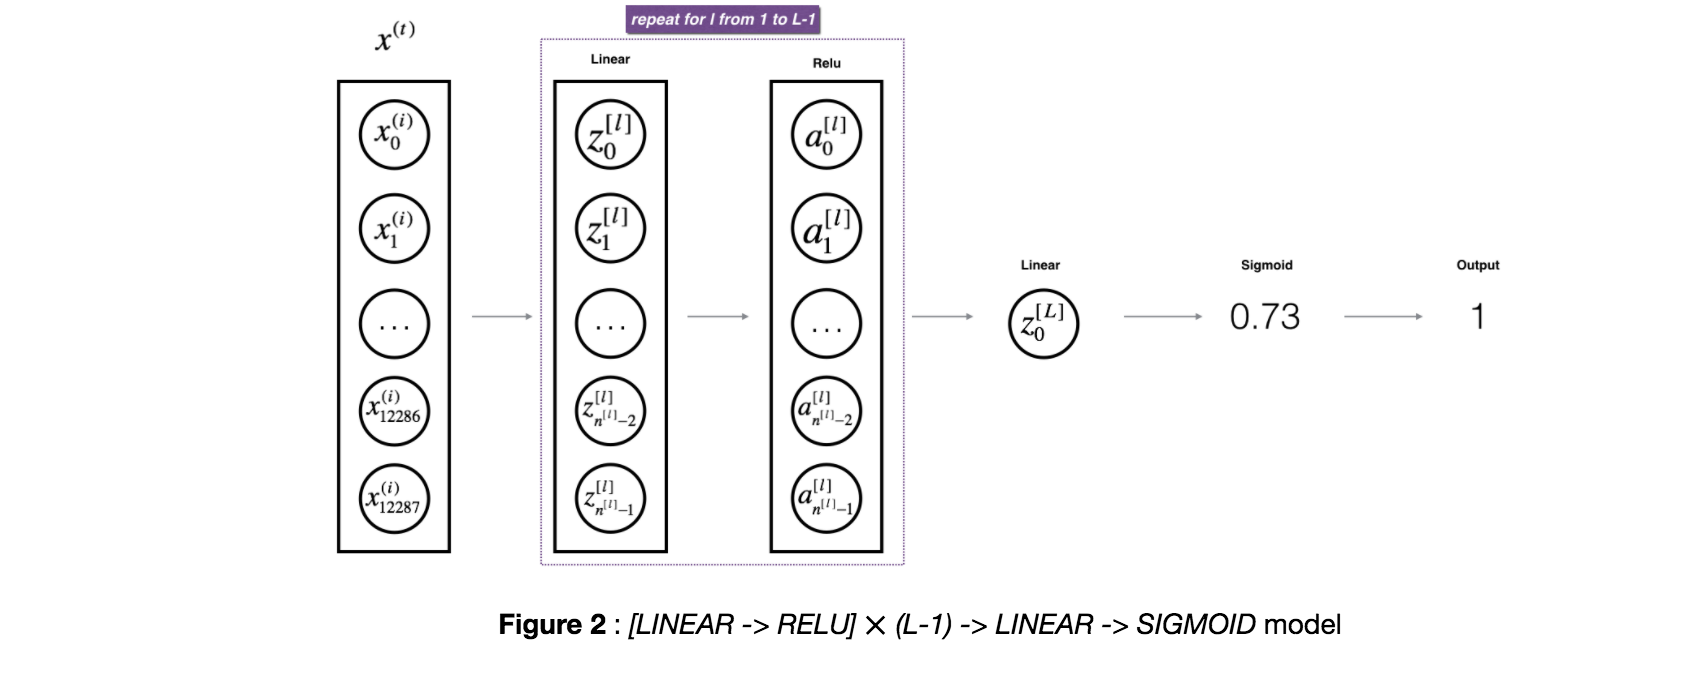

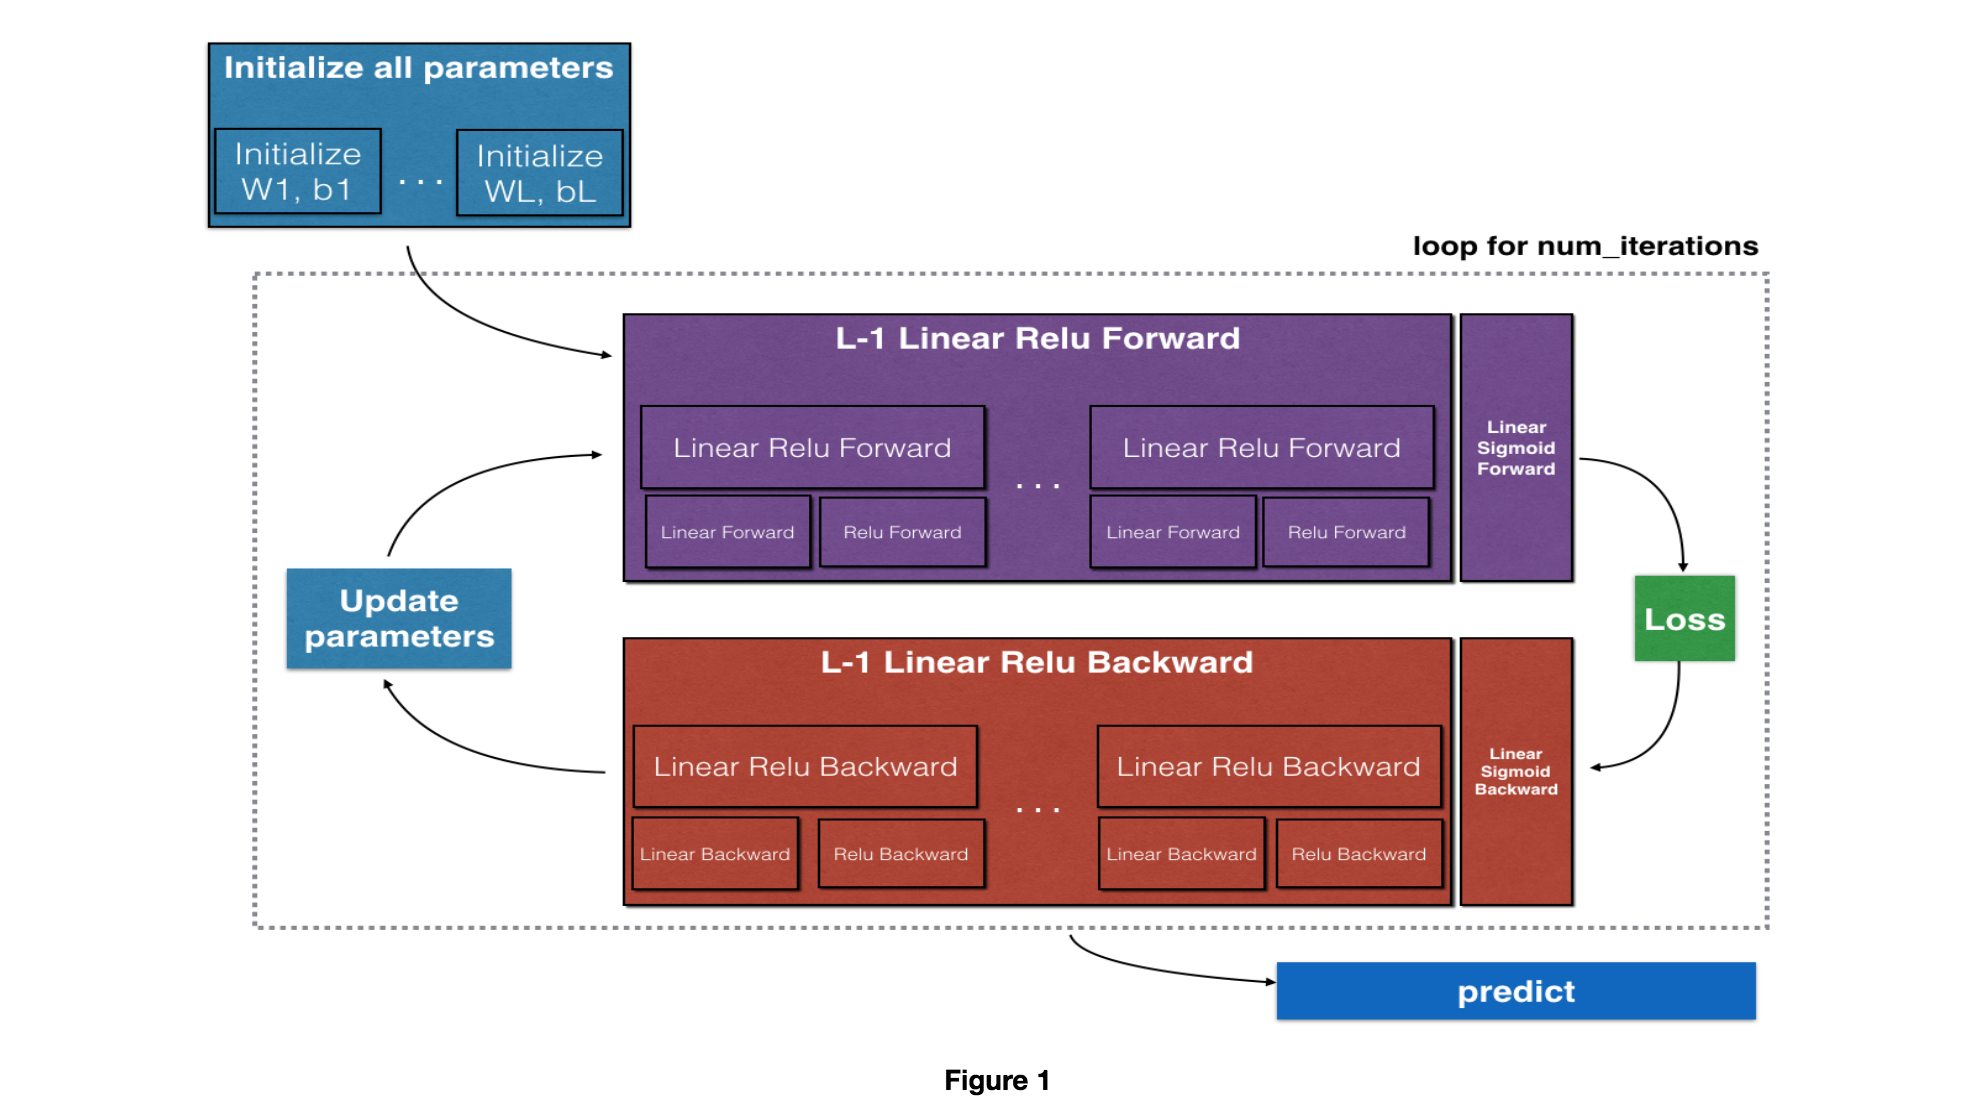

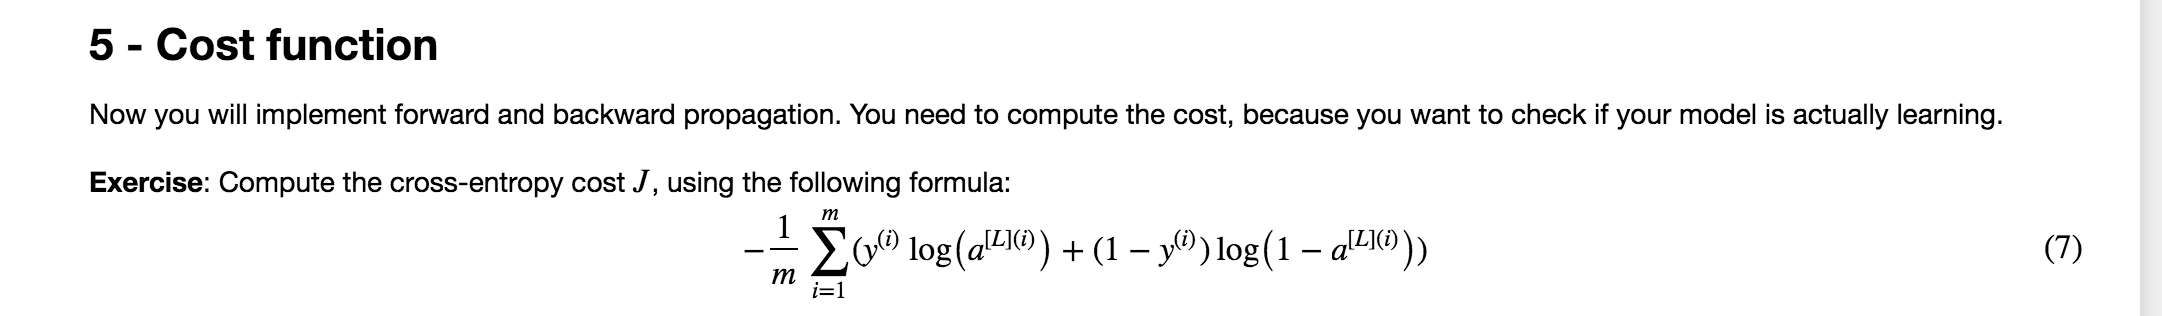

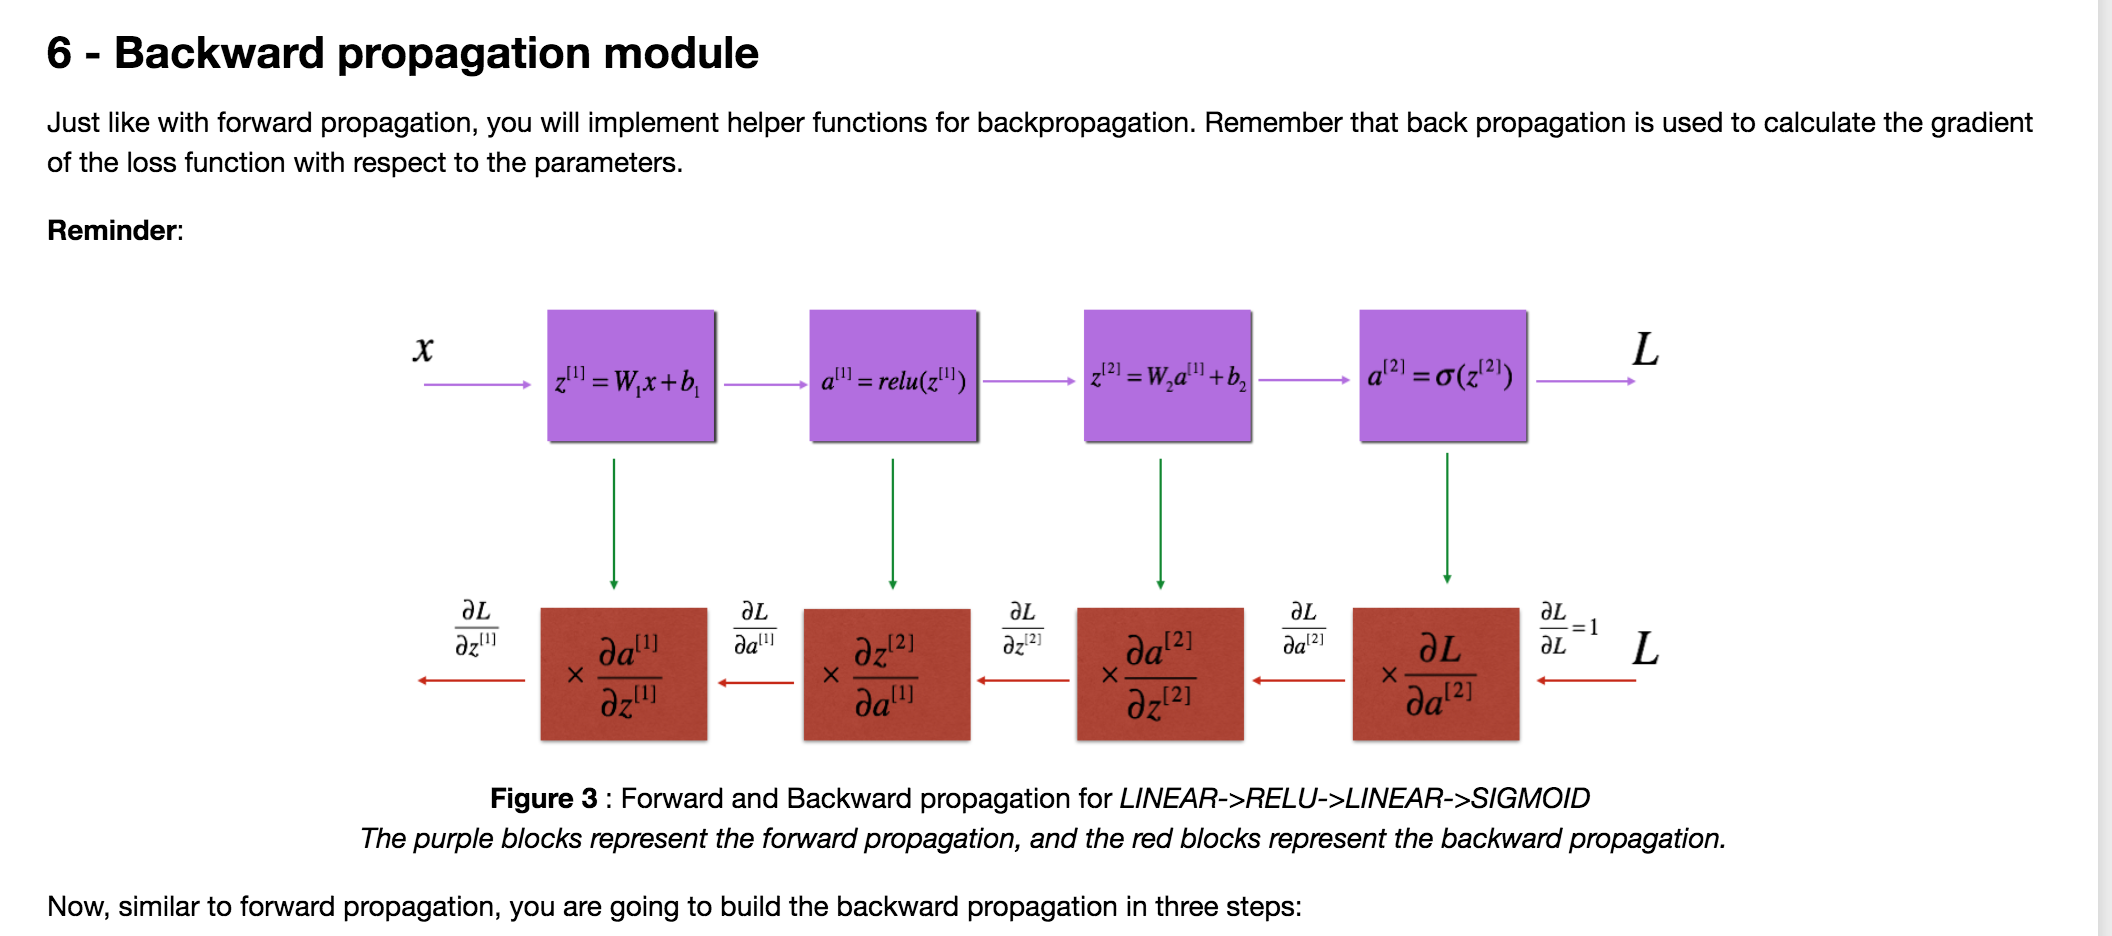

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]} dA^{[l-1]})$.

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$

In [464]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Linear:
    def __init__(self):
        pass
    def __call__(self, x):
        return x
    def derivative(self, x):
        return x

In [3]:
class ReLu:
    def __init__(self):
        pass
    
    def __call__(self, x):
        return np.maximum(x, 0)
    
    def derivative(self, x):
        return (x > 0) * 1

In [102]:
class Sigmoid:
    def __init__(self):
        pass
    
    def __call__(self, x):
        res = 1 / (1 + np.exp(-x))
        return res
    
    def derivative(self, x):
        return self(x) * (1 - self(x))

In [103]:
class NLLLoss:
    def __init__(self):
        pass
    def __call__(self, x, y):
        m, _ = x.shape
        cost = - (np.dot(y.T, np.log(x)) + np.dot((1 - y).T, np.log(1 - x))) / m
        
        return np.squeeze(cost)
    
    def derivative(self, x, y):
        res = -(np.divide(y, x) - np.divide(1 - y, 1 - x))
        return res

In [425]:
class DenseLayer:
    def __init__(self, n_in, n_out, activation = Linear()):
        self.n_in = n_in
        self.n_out = n_out
        self.w = np.random.randn(n_out, n_in)
        self.b = np.zeros(n_out)
        self.g = activation
        
    def forward(self, x):
        self.x_cached = x
        linear = np.dot(x, self.w.T) + self.b
        self.z_cached = self.g(linear)
        return self.z_cached
    
    def backward(self, dA):
        dZ = dA * self.g.derivative(self.z_cached)
        size, _ = dZ.shape
        dW = np.dot(dZ.T, self.x_cached) / size
        db = np.average(dZ)
        dA_prev = np.dot(dZ, self.w)
        self.w_update = dW
        self.b_update = db
        return dA_prev
    
    def update(self, rate = 0.1):
        self.w = self.w - self.w_update * rate
        self.b = self.b - self.b_update * rate
        
    
    def __repr__(self):
        return "Dense" + str(self.w.shape)
    

In [426]:
class Sequence:
    def __init__(self, layers, rate = 0.01):
        self.layers = layers
        self.rate = rate

    def forward(self, x):
        a = x
        for layer in self.layers:
            a = layer.forward(a)
        return a
    
    def backward(self, dAL):
        dA = dAL
        for layer in reversed(self.layers):
            dA = layer.backward(dA)
        return dA
    
    def update(self):
        for layer in reversed(self.layers):
            layer.update(self.rate)
        
    

In [427]:
def plot_data(data, predicted, costs):
	x, y = data
	fig, (g1,g2) = plt.subplots(nrows = 2, ncols = 1)
	g1.plot(x, y, 'bo', markersize = 5)
	g1.plot(x, predicted,'ro', markersize = 3)
	g1.axis([x.min() - x.mean(), x.max() + x.mean(), y.min() - y.mean(), y.max() + y.mean()])
	g2.plot(costs)
	plt.show()
    
def split_data(data):
	examples, features = data.shape
	#features - 1 because last column is value we are trying to predict
	return (data[0:,:features - 1], data[0:, features - 1].reshape(-1, 1))

def compute_accuracy(net, x, y):
    predictions = (net.forward(x) > 0.5) * 1
    size, _ = x.shape
    truth = np.sum( (predictions == y) * 1)
    acc = truth / size
    return acc;

def bound(net, pivot = 0.5, precision = 0.005):
    xs = np.arange(-1, 1, 0.005)
    ys = np.arange(-1, 1, 0.005)
    pts = []
    for i in xs:
        for j in ys:
            if pivot - precision < np.abs(net.forward(np.array([[i, j]]))).squeeze() < pivot + precision:
                pts.append((i, j))
    return pts

def plot_decision(net, x,  pivot = 0.5, precision = 0.005):
    bounds = bound(net, pivot, precision)
    res = net.forward(x)
    plt.plot(np.array(bounds)[0:,0], np.array(bounds)[0:,1],'go', markersize=1)
#     plt.plot(x[np.where(y==0),0], x[np.where(y==0), 1], 'ro')
#     plt.plot(x[np.where(y==1),0], x[np.where(y==1), 1], 'rx')
    
    plt.plot(x[np.where(res >= 0.5), 0], x[np.where(res >= 0.5), 1], 'ro', markersize=6)
    plt.plot(x[np.where(res < 0.5), 0], x[np.where(res < 0.5), 1], 'bx', markersize=5)
    
    
    plt.show()
    

In [428]:
data = np.genfromtxt("w2/ex2data2.txt",  delimiter = ",")

In [466]:
x, y = split_data(data)

In [480]:
net = Sequence([
    DenseLayer(2, 20, activation=ReLu()),
    DenseLayer(20, 1, activation=Sigmoid())
], rate = 0.001)

loss = NLLLoss()

In [491]:

for i in range(2000):
    res = net.forward(x)
    loss_value = loss(res, y)
    dA = loss.derivative(res, y)
    net.backward(dA)
    if i % 1000 == 999:
        acc = compute_accuracy(net, x, y)
        print("Loss: " + str(loss_value), " Acc: " + str(acc))
        
    net.update()


Loss: 0.6009798607628863  Acc: 0.677966101695
Loss: 0.5972047155725708  Acc: 0.677966101695


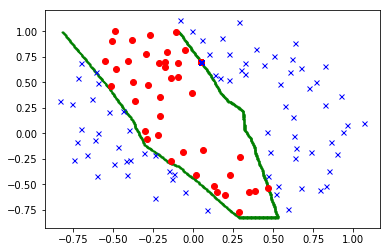

In [497]:
plot_decision(net, x, precision=0.002)

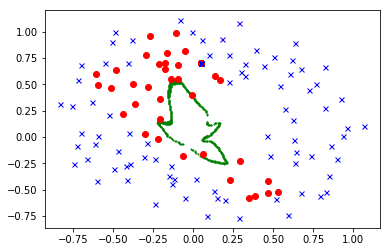

In [446]:
plot_decision(net, x, pivot=0.7, precision=0.002)